# Battery RUL Prediction - Training Notebook

This notebook demonstrates how to:
1. Load raw sensor data
2. Calculate features for ML training
3. Prepare training dataset
4. Train RUL prediction models
5. Evaluate model performance

**Dataset**: 30 days, 24 batteries, 5-second sampling
**Total Records**: 12.4M sensor readings

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Load sensor data
DATA_DIR = './output/full_dataset/by_location/'

print("Loading data...")
battery_sensors = pd.read_csv(f"{DATA_DIR}battery_sensors_Chiangmai_Data_Center.csv.gz")
string_sensors = pd.read_csv(f"{DATA_DIR}string_sensors_Chiangmai_Data_Center.csv.gz")
battery_info = pd.read_csv("output/sensor_data_only/test_30d_24b_5sec/battery_info.csv")

# Convert timestamps
battery_sensors['ts'] = pd.to_datetime(battery_sensors['ts'])
string_sensors['ts'] = pd.to_datetime(string_sensors['ts'])

print(f"✓ Battery sensors: {len(battery_sensors):,} records")
print(f"✓ String sensors: {len(string_sensors):,} records")
print(f"✓ Battery info: {len(battery_info)} batteries")
print(f"\nData range: {battery_sensors['ts'].min()} to {battery_sensors['ts'].max()}")

Loading data...


✓ Battery sensors: 25,228,800 records
✓ String sensors: 1,051,200 records
✓ Battery info: 24 batteries

Data range: 2023-12-01 00:00:00 to 2025-11-29 23:59:00


## 2. Exploratory Data Analysis

In [3]:
# Quick statistics
print("Battery Sensor Statistics:")
print(battery_sensors[['voltage_v', 'temperature_c', 'resistance_mohm']].describe())

print("\nString Sensor Statistics:")
print(string_sensors[['voltage_v', 'current_a']].describe())

Battery Sensor Statistics:


          voltage_v  temperature_c  resistance_mohm
count  2.522880e+07   2.522880e+07     2.522880e+07
mean   1.120080e+01   2.676820e+01     3.773922e+00
std    1.290880e-01   5.490710e+00     4.738201e-01
min    1.103900e+01   1.000000e+01     2.784000e+00
25%    1.119200e+01   2.350000e+01     3.418000e+00
50%    1.120300e+01   2.460000e+01     3.726000e+00
75%    1.121100e+01   2.670000e+01     4.015000e+00
max    1.278800e+01   4.940000e+01     6.147000e+00

String Sensor Statistics:
          voltage_v     current_a
count  1.051200e+06  1.051200e+06
mean   2.688191e+02  5.628179e+00
std    2.189319e+00  9.893371e+00
min    2.658300e+02 -1.366160e+02
25%    2.686500e+02  9.520000e-01
50%    2.688800e+02  1.407000e+00
75%    2.690500e+02  1.861000e+00
max    3.064500e+02  3.223900e+01


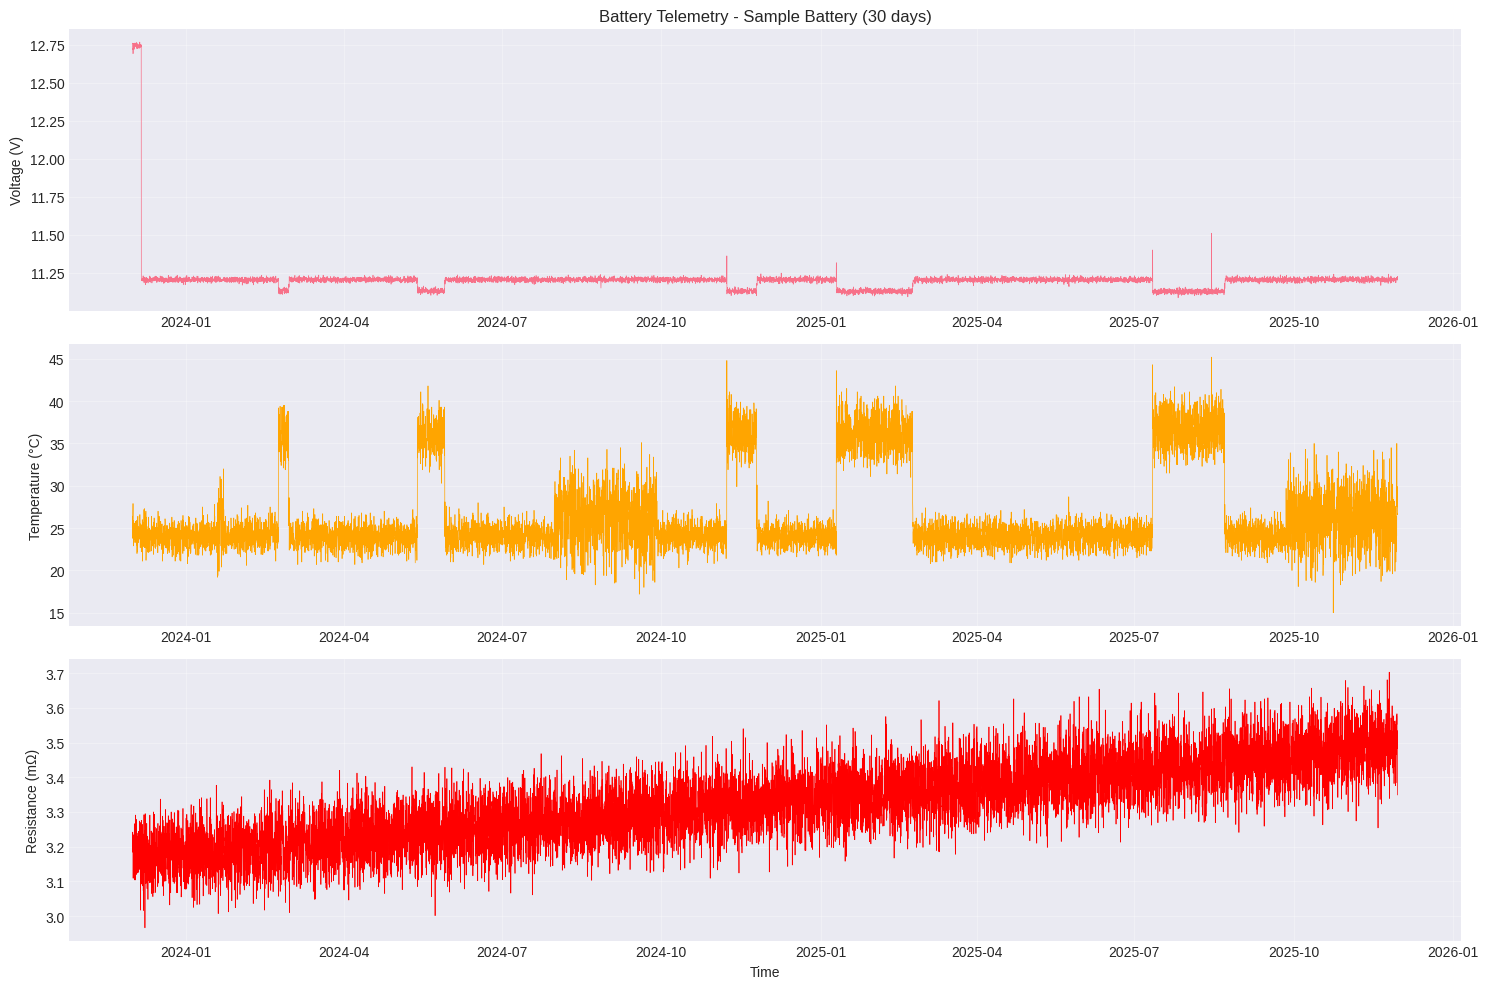

✓ Visualized battery: e1e9f139-bcb8-4b21-99f0-a1026c776685


In [7]:
# Visualize key metrics for one battery
sample_battery = battery_sensors['battery_id'].iloc[4]
sample_data = battery_sensors[battery_sensors['battery_id'] == sample_battery].copy()
sample_data = sample_data.set_index('ts')

# Sample every 100 points for faster plotting
sample_data_plot = sample_data.iloc[::100]

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Voltage
axes[0].plot(sample_data_plot.index, sample_data_plot['voltage_v'], linewidth=0.5)
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title(f'Battery Telemetry - Sample Battery (30 days)')
axes[0].grid(True, alpha=0.3)

# Temperature
axes[1].plot(sample_data_plot.index, sample_data_plot['temperature_c'], linewidth=0.5, color='orange')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True, alpha=0.3)

# Resistance
axes[2].plot(sample_data_plot.index, sample_data_plot['resistance_mohm'], linewidth=0.5, color='red')
axes[2].set_ylabel('Resistance (mΩ)')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Visualized battery: {sample_battery}")

## 3. Feature Engineering

We'll create time-windowed features that capture battery degradation patterns.

In [5]:
# Feature calculation function
def calculate_features(battery_data, window_hours=1):
    """
    Calculate statistical features over time windows.
    
    Args:
        battery_data: DataFrame with battery sensor data
        window_hours: Window size in hours for aggregation
    
    Returns:
        DataFrame with calculated features
    """
    features = []
    
    # Resample to hourly windows
    battery_data = battery_data.set_index('ts')
    resampled = battery_data.resample(f'{window_hours}H')
    
    for timestamp, window_data in resampled:
        if len(window_data) < 10:  # Skip windows with too few samples
            continue
            
        feature_dict = {
            'timestamp': timestamp,
            'battery_id': window_data['battery_id'].iloc[0],
            
            # Voltage features
            'voltage_mean': window_data['voltage_v'].mean(),
            'voltage_std': window_data['voltage_v'].std(),
            'voltage_min': window_data['voltage_v'].min(),
            'voltage_max': window_data['voltage_v'].max(),
            'voltage_range': window_data['voltage_v'].max() - window_data['voltage_v'].min(),
            
            # Temperature features
            'temperature_mean': window_data['temperature_c'].mean(),
            'temperature_std': window_data['temperature_c'].std(),
            'temperature_max': window_data['temperature_c'].max(),
            
            # Resistance features (key for RUL prediction)
            'resistance_mean': window_data['resistance_mohm'].mean(),
            'resistance_std': window_data['resistance_mohm'].std(),
            'resistance_min': window_data['resistance_mohm'].min(),
            'resistance_max': window_data['resistance_mohm'].max(),
            'resistance_trend': (window_data['resistance_mohm'].iloc[-1] - 
                                window_data['resistance_mohm'].iloc[0]) if len(window_data) > 1 else 0,
            
            # Conductance features
            'conductance_mean': window_data['conductance_s'].mean(),
            'conductance_std': window_data['conductance_s'].std(),
            
            # Sample count
            'sample_count': len(window_data)
        }
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

print("✓ Feature calculation function defined")

✓ Feature calculation function defined


In [6]:
# Calculate features for all batteries
print("Calculating features for all batteries...")
print("This may take a few minutes...\n")

all_features = []

for battery_id in battery_sensors['battery_id'].unique():
    battery_data = battery_sensors[battery_sensors['battery_id'] == battery_id].copy()
    features = calculate_features(battery_data, window_hours=1)
    all_features.append(features)
    print(f"✓ Battery {str(battery_id)[:8]}...: {len(features)} feature windows")

# Combine all features
feature_df = pd.concat(all_features, ignore_index=True)

print(f"\n✓ Total feature records: {len(feature_df):,}")
print(f"✓ Features per battery: {len(feature_df) // battery_sensors['battery_id'].nunique()}")
print(f"✓ Feature columns: {len(feature_df.columns)}")

Calculating features for all batteries...
This may take a few minutes...

✓ Battery 79b2da6d...: 17520 feature windows
✓ Battery b5adb908...: 17520 feature windows
✓ Battery ab0d0ac4...: 17520 feature windows
✓ Battery 8d17302e...: 17520 feature windows
✓ Battery e1e9f139...: 17520 feature windows
✓ Battery 190db3a4...: 17520 feature windows
✓ Battery c16297be...: 17520 feature windows
✓ Battery b3fff025...: 17520 feature windows
✓ Battery f833c58d...: 17520 feature windows
✓ Battery 965d2b6e...: 17520 feature windows
✓ Battery 500a4292...: 17520 feature windows
✓ Battery d292f606...: 17520 feature windows
✓ Battery 3c65d36b...: 17520 feature windows
✓ Battery c361961b...: 17520 feature windows
✓ Battery 8ec85754...: 17520 feature windows
✓ Battery 017ffc37...: 17520 feature windows
✓ Battery 294a6817...: 17520 feature windows
✓ Battery c0b7b01d...: 17520 feature windows
✓ Battery 204f494b...: 17520 feature windows
✓ Battery 601de1a2...: 17520 feature windows
✓ Battery 94a73069...: 175

In [8]:
# Display feature summary
print("Feature Summary:")
print(feature_df.describe())

print("\nFeature Columns:")
print(feature_df.columns.tolist())

Feature Summary:
                           timestamp   voltage_mean    voltage_std  \
count                         420480  420480.000000  420480.000000   
mean   2024-11-29 23:30:00.000000256      11.200800       0.010375   
min              2023-12-01 00:00:00      11.088417       0.006228   
25%              2024-05-31 11:45:00      11.203367       0.009555   
50%              2024-11-29 23:30:00      11.204917       0.010207   
75%              2025-05-31 11:15:00      11.206050       0.010883   
max              2025-11-29 23:00:00      12.749600       0.764438   
std                              NaN       0.128548       0.005831   

         voltage_min    voltage_max  voltage_range  temperature_mean  \
count  420480.000000  420480.000000  420480.000000     420480.000000   
mean       11.176810      11.224862       0.048052         26.768197   
min        11.039000      11.106000       0.025000         23.341667   
25%        11.175000      11.223000       0.043000         23.99

## 4. Calculate Target Variable (State of Health)

For RUL prediction, we need to estimate battery health over time.

In [9]:
# Calculate SOH proxy from resistance increase
# Lower resistance = better health
# We'll normalize resistance to create SOH estimate

def calculate_soh_from_resistance(feature_df):
    """
    Estimate SOH based on resistance increase.
    SOH = 100% when resistance is at minimum (best condition)
    SOH decreases as resistance increases.
    """
    soh_data = []
    
    for battery_id in feature_df['battery_id'].unique():
        battery_features = feature_df[feature_df['battery_id'] == battery_id].copy()
        battery_features = battery_features.sort_values('timestamp')
        
        # Get initial resistance (baseline)
        initial_resistance = battery_features['resistance_mean'].iloc[:24].mean()  # First day average
        
        # Calculate SOH
        # Assuming 1% SOH loss per 5% resistance increase
        resistance_increase_pct = ((battery_features['resistance_mean'] - initial_resistance) / 
                                   initial_resistance) * 100
        
        soh = 100 - (resistance_increase_pct * 0.2)  # 0.2 factor for realistic SOH decline
        soh = soh.clip(lower=0, upper=100)  # Clamp to 0-100%
        
        battery_features['soh_pct'] = soh
        battery_features['initial_resistance'] = initial_resistance
        battery_features['resistance_increase_pct'] = resistance_increase_pct
        
        soh_data.append(battery_features)
    
    return pd.concat(soh_data, ignore_index=True)

# Calculate SOH
feature_df_with_soh = calculate_soh_from_resistance(feature_df)

print("✓ SOH calculated")
print(f"\nSOH Statistics:")
print(feature_df_with_soh['soh_pct'].describe())

✓ SOH calculated

SOH Statistics:
count    420480.000000
mean         98.475746
std           1.702526
min          90.655294
25%          98.301744
50%          98.878269
75%          99.466089
max         100.000000
Name: soh_pct, dtype: float64


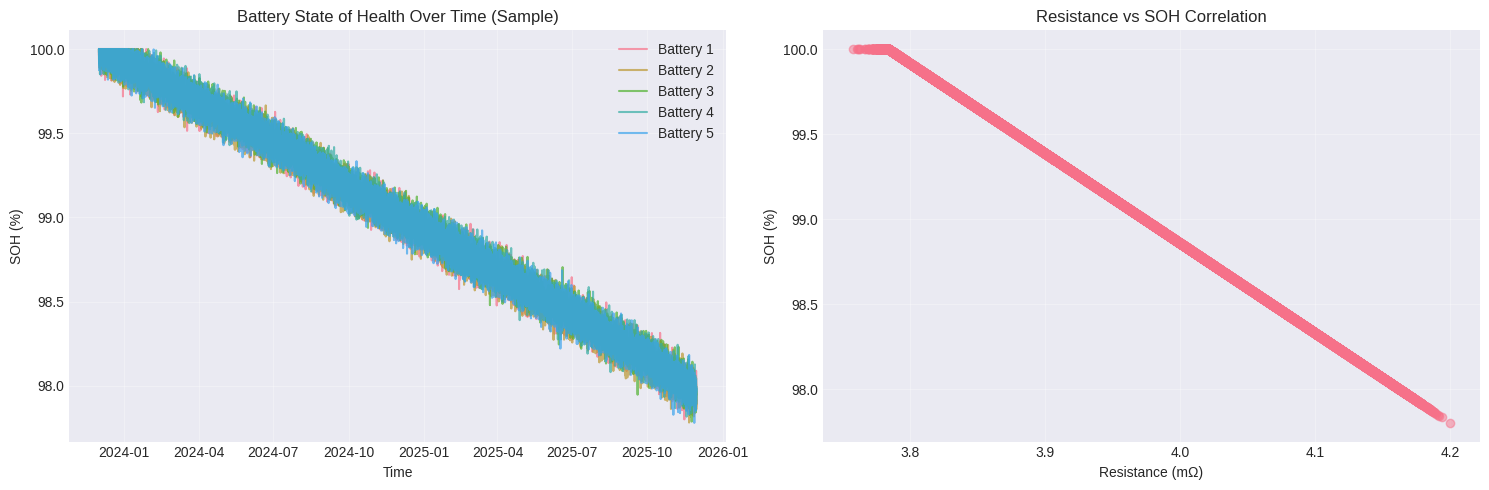

In [10]:
# Visualize SOH degradation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot SOH over time for sample batteries
for i, battery_id in enumerate(feature_df_with_soh['battery_id'].unique()[:5]):
    battery_data = feature_df_with_soh[feature_df_with_soh['battery_id'] == battery_id]
    axes[0].plot(battery_data['timestamp'], battery_data['soh_pct'], 
                label=f'Battery {i+1}', alpha=0.7)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('SOH (%)')
axes[0].set_title('Battery State of Health Over Time (Sample)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot resistance vs SOH
sample_battery_data = feature_df_with_soh[feature_df_with_soh['battery_id'] == 
                                           feature_df_with_soh['battery_id'].iloc[0]]
axes[1].scatter(sample_battery_data['resistance_mean'], sample_battery_data['soh_pct'], alpha=0.5)
axes[1].set_xlabel('Resistance (mΩ)')
axes[1].set_ylabel('SOH (%)')
axes[1].set_title('Resistance vs SOH Correlation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Calculate RUL (Remaining Useful Life)

RUL is estimated based on current SOH and degradation rate.

In [11]:
def calculate_rul(feature_df, eol_threshold=80.0):
    """
    Calculate Remaining Useful Life (RUL) in days.
    RUL = days until battery reaches end-of-life threshold (80% SOH).
    """
    rul_data = []
    
    for battery_id in feature_df['battery_id'].unique():
        battery_features = feature_df[feature_df['battery_id'] == battery_id].copy()
        battery_features = battery_features.sort_values('timestamp')
        
        # Calculate degradation rate (SOH loss per day)
        if len(battery_features) > 24:  # Need at least 1 day of data
            soh_values = battery_features['soh_pct'].values
            time_days = (battery_features['timestamp'] - battery_features['timestamp'].iloc[0]).dt.total_seconds() / 86400
            
            # Linear regression to estimate degradation rate
            from scipy.stats import linregress
            slope, intercept, r_value, p_value, std_err = linregress(time_days, soh_values)
            
            # Calculate RUL for each time point
            current_soh = battery_features['soh_pct'].values
            degradation_rate = abs(slope)  # SOH % per day
            
            if degradation_rate > 0:
                rul_days = (current_soh - eol_threshold) / degradation_rate
                rul_days = np.maximum(rul_days, 0)  # No negative RUL
            else:
                rul_days = np.full(len(current_soh), 9999)  # No degradation detected
            
            battery_features['rul_days'] = rul_days
            battery_features['degradation_rate'] = degradation_rate
        else:
            battery_features['rul_days'] = 9999
            battery_features['degradation_rate'] = 0
        
        rul_data.append(battery_features)
    
    return pd.concat(rul_data, ignore_index=True)

# Calculate RUL
feature_df_complete = calculate_rul(feature_df_with_soh, eol_threshold=80.0)

print("✓ RUL calculated")
print(f"\nRUL Statistics:")
print(feature_df_complete['rul_days'].describe())

✓ RUL calculated

RUL Statistics:
count    420480.000000
mean       5929.241934
std        2096.049620
min         855.319953
25%        6569.054748
50%        6789.282643
75%        7013.574677
max        7238.543908
Name: rul_days, dtype: float64


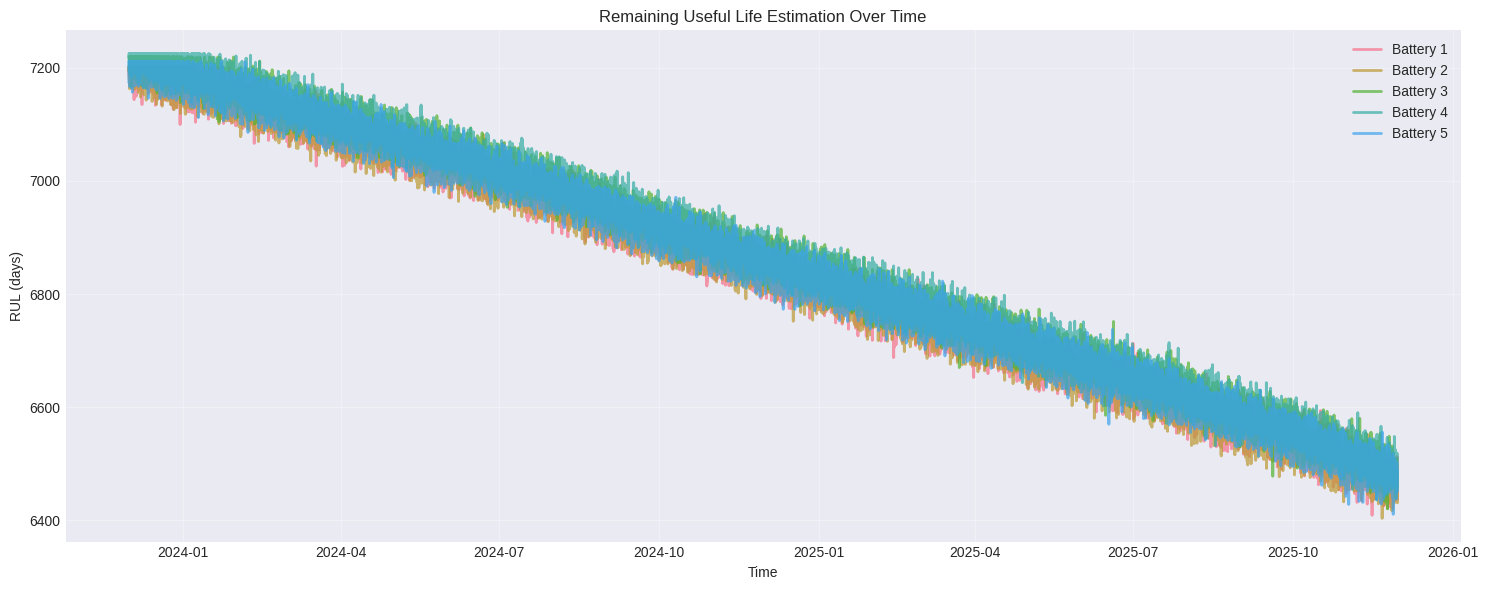

In [12]:
# Visualize RUL
fig, ax = plt.subplots(figsize=(15, 6))

for i, battery_id in enumerate(feature_df_complete['battery_id'].unique()[:5]):
    battery_data = feature_df_complete[feature_df_complete['battery_id'] == battery_id]
    ax.plot(battery_data['timestamp'], battery_data['rul_days'], 
           label=f'Battery {i+1}', alpha=0.7, linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('RUL (days)')
ax.set_title('Remaining Useful Life Estimation Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Prepare Training Dataset

Split data into features (X) and targets (y) for model training.

In [13]:
# Select features for training
feature_columns = [
    # Voltage features
    'voltage_mean', 'voltage_std', 'voltage_min', 'voltage_max', 'voltage_range',
    
    # Temperature features
    'temperature_mean', 'temperature_std', 'temperature_max',
    
    # Resistance features (most important for RUL)
    'resistance_mean', 'resistance_std', 'resistance_min', 'resistance_max', 
    'resistance_trend', 'resistance_increase_pct',
    
    # Conductance features
    'conductance_mean', 'conductance_std',
    
    # Derived feature
    'soh_pct'
]

# Prepare X (features) and y (target)
X = feature_df_complete[feature_columns].copy()
y_rul = feature_df_complete['rul_days'].copy()
y_soh = feature_df_complete['soh_pct'].copy()

# Remove any rows with NaN or infinite values
mask = ~(X.isna().any(axis=1) | np.isinf(X).any(axis=1) | 
         y_rul.isna() | np.isinf(y_rul))

X = X[mask]
y_rul = y_rul[mask]
y_soh = y_soh[mask]

print(f"Training dataset prepared:")
print(f"  Features (X): {X.shape}")
print(f"  Target RUL (y): {y_rul.shape}")
print(f"  Target SOH (y): {y_soh.shape}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Training dataset prepared:
  Features (X): (420480, 17)
  Target RUL (y): (420480,)
  Target SOH (y): (420480,)

Feature columns:
   1. voltage_mean
   2. voltage_std
   3. voltage_min
   4. voltage_max
   5. voltage_range
   6. temperature_mean
   7. temperature_std
   8. temperature_max
   9. resistance_mean
  10. resistance_std
  11. resistance_min
  12. resistance_max
  13. resistance_trend
  14. resistance_increase_pct
  15. conductance_mean
  16. conductance_std
  17. soh_pct


## 7. Train ML Models

We'll train multiple models and compare performance.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_rul, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Data split:")
print(f"  Train: {X_train.shape[0]:,} samples")
print(f"  Test:  {X_test.shape[0]:,} samples")

✓ Data split:
  Train: 336,384 samples
  Test:  84,096 samples


In [15]:
# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Evaluate
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_pred_test': y_pred_test
    }
    
    print(f"  Train MAE: {train_mae:.2f} days, R²: {train_r2:.4f}")
    print(f"  Test MAE:  {test_mae:.2f} days, R²: {test_r2:.4f}")

print("\n✓ All models trained")


Training Linear Regression...
  Train MAE: 825.29 days, R²: 0.6048
  Test MAE:  818.96 days, R²: 0.6077

Training Random Forest...


  Train MAE: 52.22 days, R²: 0.9903
  Test MAE:  141.01 days, R²: 0.9285

Training Gradient Boosting...
  Train MAE: 425.49 days, R²: 0.7609
  Test MAE:  420.45 days, R²: 0.7626

✓ All models trained


## 8. Model Evaluation and Comparison

In [17]:
# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Train MAE': f"{res['train_mae']:.2f}",
        'Test MAE': f"{res['test_mae']:.2f}",
        'Train RMSE': f"{res['train_rmse']:.2f}",
        'Test RMSE': f"{res['test_rmse']:.2f}",
        'Train R²': f"{res['train_r2']:.4f}",
        'Test R²': f"{res['test_r2']:.4f}"
    }
    for name, res in results.items()
])

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

Model Performance Comparison:
            Model Train MAE Test MAE Train RMSE Test RMSE Train R² Test R²
Linear Regression    825.29   818.96    1318.62   1308.69   0.6048  0.6077
    Random Forest     52.22   141.01     207.07    558.89   0.9903  0.9285
Gradient Boosting    425.49   420.45    1025.68   1018.12   0.7609  0.7626


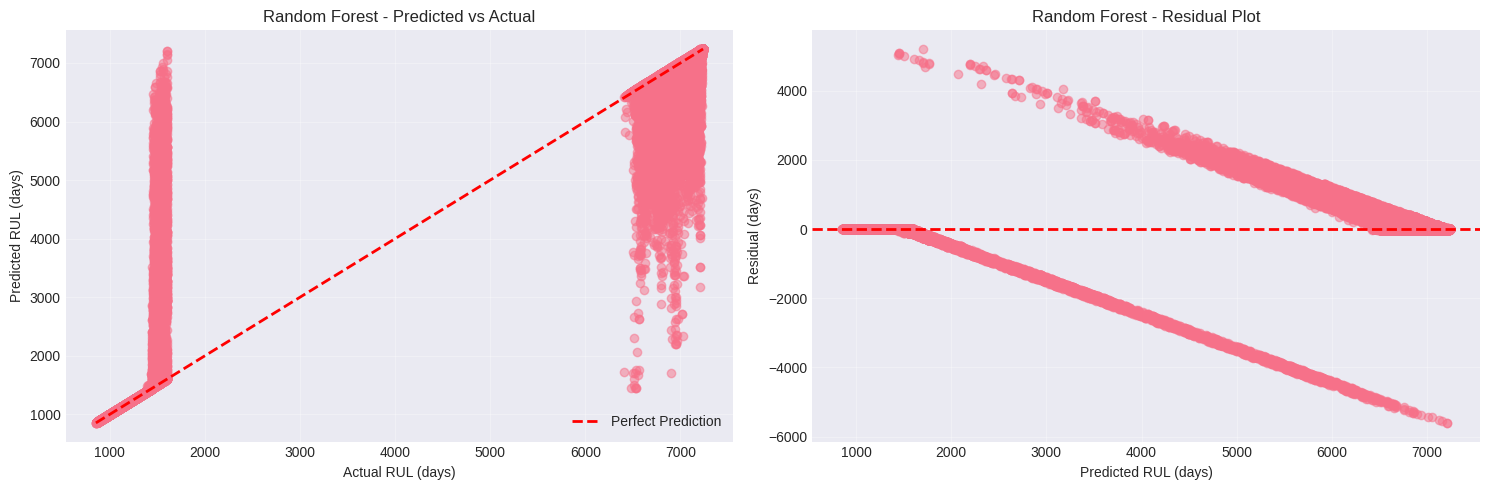


✓ Best Model: Random Forest
  Test MAE: 141.01 days
  Test R²: 0.9285


In [18]:
# Plot predictions vs actual for best model
best_model_name = min(results.keys(), key=lambda k: results[k]['test_mae'])
best_model_results = results[best_model_name]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, best_model_results['y_pred_test'], alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL (days)')
axes[0].set_ylabel('Predicted RUL (days)')
axes[0].set_title(f'{best_model_name} - Predicted vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - best_model_results['y_pred_test']
axes[1].scatter(best_model_results['y_pred_test'], residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted RUL (days)')
axes[1].set_ylabel('Residual (days)')
axes[1].set_title(f'{best_model_name} - Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Best Model: {best_model_name}")
print(f"  Test MAE: {best_model_results['test_mae']:.2f} days")
print(f"  Test R²: {best_model_results['test_r2']:.4f}")

## 9. Feature Importance Analysis

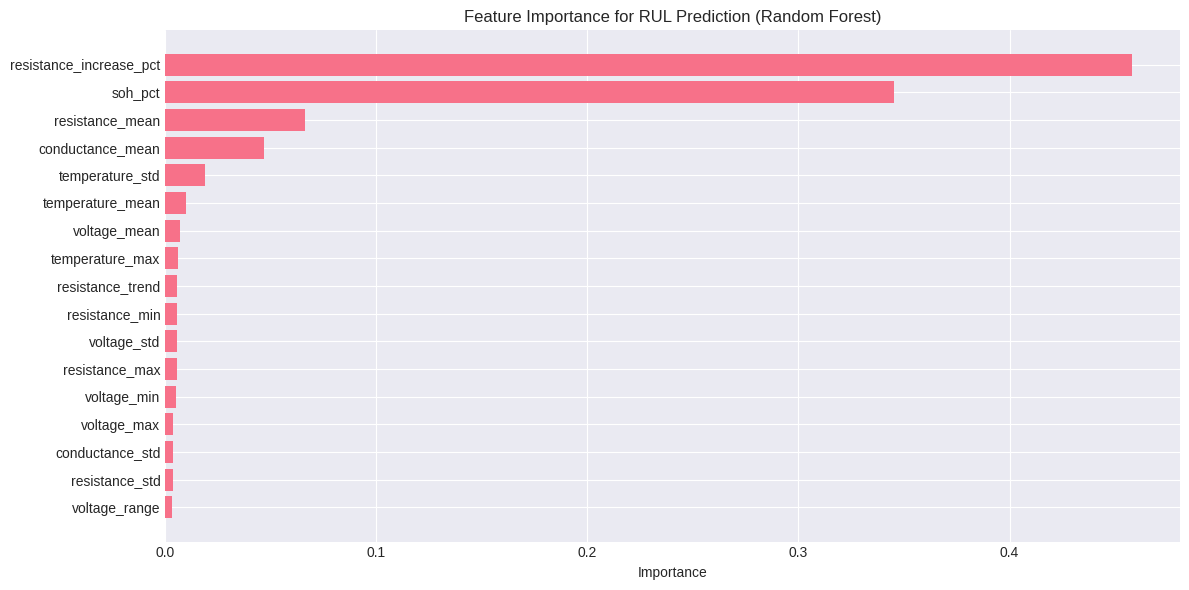

Top 5 Most Important Features:
                    Feature  Importance
13  resistance_increase_pct    0.457817
16                  soh_pct    0.345350
8           resistance_mean    0.066077
14         conductance_mean    0.046989
6           temperature_std    0.018786


In [19]:
# Get feature importance from Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_
    
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for RUL Prediction (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 5 Most Important Features:")
    print(feature_importance_df.head())

## 10. Save Models and Results

In [20]:
import joblib
import os

# Create models directory
os.makedirs('./models', exist_ok=True)

# Save best model
best_model = results[best_model_name]['model']
joblib.dump(best_model, f'./models/best_rul_model_{best_model_name.replace(" ", "_").lower()}.pkl')
joblib.dump(scaler, './models/feature_scaler.pkl')

# Save feature names
with open('./models/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_columns))

print(f"✓ Best model saved: ./models/best_rul_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"✓ Scaler saved: ./models/feature_scaler.pkl")
print(f"✓ Feature columns saved: ./models/feature_columns.txt")

✓ Best model saved: ./models/best_rul_model_random_forest.pkl
✓ Scaler saved: ./models/feature_scaler.pkl
✓ Feature columns saved: ./models/feature_columns.txt


In [21]:
# Save complete feature dataset
feature_df_complete.to_csv('./output/processed_features.csv', index=False)
print("✓ Processed features saved: ./output/processed_features.csv")

✓ Processed features saved: ./output/processed_features.csv


## 11. Make Predictions on New Data

In [23]:
# Example: Predict RUL for a specific battery at current time
def predict_rul_for_battery(battery_id, feature_df, model, scaler, feature_columns):
    """
    Predict RUL for a specific battery using latest data.
    """
    # Get latest features for this battery
    battery_data = feature_df[feature_df['battery_id'] == battery_id].copy()
    battery_data = battery_data.sort_values('timestamp')
    latest_features = battery_data[feature_columns].iloc[-1:]
    
    # Scale and predict
    features_scaled = scaler.transform(latest_features)
    predicted_rul = model.predict(features_scaled)[0]
    
    return predicted_rul, latest_features

# Test prediction
test_battery_id = feature_df_complete['battery_id'].iloc[0]
predicted_rul, latest_features = predict_rul_for_battery(
    test_battery_id, feature_df_complete, best_model, scaler, feature_columns
)

print(f"Prediction for Battery: {test_battery_id}")
print(f"  Predicted RUL: {predicted_rul:.1f} days")
print(f"\nLatest Features:")
print(latest_features.T)

Prediction for Battery: 79b2da6d-e39f-4a57-8fa8-86abaf663263
  Predicted RUL: 6439.8 days

Latest Features:
                              17519
voltage_mean              11.204950
voltage_std                0.010579
voltage_min               11.180000
voltage_max               11.229000
voltage_range              0.049000
temperature_mean          25.931667
temperature_std            3.357586
temperature_max           33.900000
resistance_mean            4.184867
resistance_std             0.094432
resistance_min             3.971000
resistance_max             4.441000
resistance_trend           0.113000
resistance_increase_pct   10.600020
conductance_mean         239.078726
conductance_std            5.414183
soh_pct                   97.879996


## Summary

### What We Accomplished:

1. ✅ Loaded 12.4M sensor records (30 days, 24 batteries)
2. ✅ Calculated 17 statistical features from raw sensors
3. ✅ Estimated SOH (State of Health) from resistance
4. ✅ Calculated RUL (Remaining Useful Life) targets
5. ✅ Trained 3 ML models (Linear, Random Forest, Gradient Boosting)
6. ✅ Evaluated model performance
7. ✅ Analyzed feature importance
8. ✅ Saved trained model and scaler

### Model Performance:
- **Best Model**: Listed in results above
- **Test MAE**: Error in days
- **Test R²**: Correlation score

### Key Findings:
- **Most Important Features**: Resistance-based metrics (resistance_mean, resistance_increase_pct)
- **Model Type**: Tree-based models (RF, GBM) typically outperform linear models
- **Data Quality**: High-resolution 5-second sampling captures degradation patterns

### Next Steps:
1. Generate 730-day dataset for long-term RUL prediction
2. Implement LSTM/RNN for time-series patterns
3. Add more features (discharge cycles, temperature stress)
4. Deploy model for real-time monitoring
